# 네이버 쇼핑 리뷰 감성 분류하기(Naver Shopping Review Sentiment Analysis)

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import boto3
from smart_open import smart_open
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.client import device_lib

#### GPU가 tensorflow 연산에 활용 가능한지 체크

In [ ]:
device_lib.list_local_devices()
tf.test.is_gpu_available()

#### S3에 저장된 TXT 파일 불러오기

In [ ]:
session = boto3.Session(profile_name='default')
s3 = session.resource('s3')
bucket = s3.Bucket('potatoes3')
with smart_open('s3://potatoes3/naver_shopping.txt', 'rt', encoding='UTF8') as f2:
    data=f2.read()

total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])

#### 평점이 4, 5인 리뷰에는 레이블 1을, 평점이 1, 2인 리뷰에는 레이블 0을 부여

In [ ]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)

#### 각 역에 대해서 중복인 샘플 데이터 삭제

In [ ]:
total_data.drop_duplicates(subset=['reviews'], inplace=True)

#### 훈련 데이터와 테스트 데이터를 3:1 비율로 분리

In [ ]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)

#### 정규 표현식을 사용하여 한글을 제외하고 모두 제거

In [ ]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)

#### 테스트 데이터에 대해서도 정규 표현식을 사용하여 한글을 제외하고 모두 제거

In [ ]:
# 중복 제거
test_data.drop_duplicates(subset = ['reviews'], inplace=True) 
# 정규 표현식 수행
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 
# 공백은 Null 값으로 변경
test_data['reviews'].replace('', np.nan, inplace=True) 
# Null 값 제거
test_data = test_data.dropna(how='any')

#### 불용어를 지정하여 훈련 데이터와 테스트 데이터 내 필요없는 토큰들을 제거

In [ ]:
#형태소 분석기 Mecab
from eunjeon import Mecab
mecab = Mecab()

stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

#### 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 텍스트 데이터에 정수 인코딩 수행

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
# 단어 집합이 생성되는 동시에 각 단어에 고유한 정수 부여
# 등장 횟수가 1회인 단어들은 자연어 처리에서 배제

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

#### 단어 집합 크기를 토크나이저의 인자로 넘겨주고, 텍스트 시퀀스를 정수 시퀀스로 변환
#### 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환

In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

#### 패딩
#### 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 작업

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 80
below_threshold_len(max_len, X_train)



# 훈련용 리뷰의 99.99가 80이하의 길이를 가지기 때문에, 훈련용 리뷰를 길이 80으로 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

GRU로 네이버 쇼핑 리뷰 감성 분류
하이퍼파라미터인 임베딩 백터의 차원은 100, 은닉 상태의 크기는 128이다. 모델은 다대일 구조의 LSTM을 사용한다.
해당 모델은 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델이다.
이진 분류 문제의 경우, 출력층에 로지스틱 회귀를 사용해야 하므로 활성화 함수로는 시그모이드 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용한다.
하이퍼파라미터인 배치 크기는 64이며, 15 에포크를 수행한다.

EarlyStopping은 검증 데이터 손실이 증가하면, 과적합 징후이므로 검증 데이터 손실이 4회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료한다는 의미이다.
ModelCheckpoint를 사용하여 검증 데이터의 정확도가 이전보다 좋아질 경우에만 모델을 저장한다.
validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인한다.
검증 데이터는 기계가 훈련 데이터에 과적합되고 있는지 않은지 확인하기 위한 용도로 사용된다.

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)



loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))


# 임의의 문장에 대한 예측을 위해서는 학습하기 전 전처리를 동일하게 적용해준다. 전처리의 순서는 정규 표현식을 통한 한국어 외 문자 제거, 토큰화, 불용어 제거, 정수 인코딩, 패딩 순이다.
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    return 1
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))
    return 0

In [ ]:
model.summary()

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

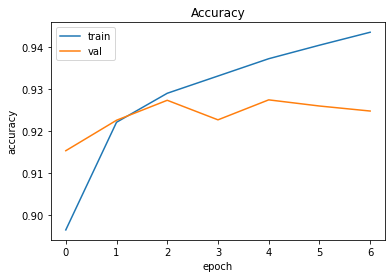

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

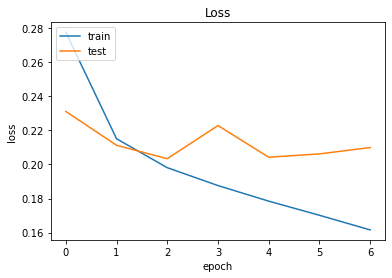